<a href="https://colab.research.google.com/github/Belajargihh/Multilabel_BillyJes_202255202106/blob/main/Multilabel_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

In [2]:
import keras
from keras.applications import MobileNetV2
from keras.models import Model
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from keras.layers import BatchNormalization
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
import os
os.environ["KAGGLE_USERNAME"] = "billyjes" # Ganti dengan username Kaggle Anda
os.environ["KAGGLE_KEY"] = "98eb717578a176d1a514fe732c425b04" # Ganti dengan key yang ada di kaggle.json

In [4]:
!kaggle datasets download -d billyjes/klasifikasi-alat-makan

Dataset URL: https://www.kaggle.com/datasets/billyjes/klasifikasi-alat-makan
License(s): unknown


In [5]:
# prompt: unzip file movie-classifier.zip

!unzip klasifikasi-alat-makan.zip


Archive:  klasifikasi-alat-makan.zip
  inflating: DatasetMultilabe_BillyJes_202255202106/Gambar001.jpg  
  inflating: DatasetMultilabe_BillyJes_202255202106/Gambar002.jpg  
  inflating: DatasetMultilabe_BillyJes_202255202106/Gambar003.jpg  
  inflating: DatasetMultilabe_BillyJes_202255202106/Gambar004.jpg  
  inflating: DatasetMultilabe_BillyJes_202255202106/Gambar005.jpg  
  inflating: DatasetMultilabe_BillyJes_202255202106/Gambar006.jpg  
  inflating: DatasetMultilabe_BillyJes_202255202106/Gambar007.jpg  
  inflating: DatasetMultilabe_BillyJes_202255202106/Gambar008.jpg  
  inflating: DatasetMultilabe_BillyJes_202255202106/Gambar009.jpg  
  inflating: DatasetMultilabe_BillyJes_202255202106/Gambar010.jpg  
  inflating: DatasetMultilabe_BillyJes_202255202106/Gambar011.jpg  
  inflating: DatasetMultilabe_BillyJes_202255202106/Gambar012.jpg  
  inflating: DatasetMultilabe_BillyJes_202255202106/Gambar013.jpg  
  inflating: DatasetMultilabe_BillyJes_202255202106/Gambar014.jpg  
  inflating

In [6]:
# Baca file CSV dengan delimiter yang sesuai
df = pd.read_csv('/content/traindataset_Billyjes_202255202106.csv', delimiter=';')

# Tampilkan 5 baris pertama dengan format tabel
display(df.head())  # Gunakan display() jika di Jupyter/Colab

,id,objek,pisau,piring,mangkok,gelas
0,Gambar001,"['pisau', 'piring', 'mangkok', 'gelas']",1,1,1,1
1,Gambar002,"['pisau', 'piring', 'gelas']",1,1,0,1
2,Gambar003,"['pisau', 'piring', 'gelas']",1,1,0,1
3,Gambar004,"['piring', 'mangkok']",0,1,1,0
4,Gambar005,"['piring', 'mangkok']",0,1,1,0


In [7]:
SIZE = 224
X_dataset = []
#Define image_directory before it's used in the loop
image_directory = '/content/DatasetMultilabe_BillyJes_202255202106/' # Change to extracted image directory
for i in tqdm(range(df.shape[0])):
    # Added '/' as a separator between image_directory and filename
    img = image.load_img(image_directory + '/' + df['id'][i]+'.jpg', target_size=(SIZE,SIZE,3))
    img = image.img_to_array(img)
    img = img/255.
    X_dataset.append(img)

X = np.array(X_dataset)

100%|██████████| 300/300 [00:21<00:00, 13.83it/s]


In [8]:
#
print(df['id'][250])  #Alat_Makan


Gambar251


In [9]:
print(df['objek'][250])  #Tagged as multiple Object.

['pisau', 'piring', 'mangkok', 'gelas']


In [10]:
#Id and Object are not labels to be trained. So drop them from the dataframe.
#No need to convert to categorical as the dataset is already in the right format.
y = np.array(df.drop(['id', 'objek'], axis=1))

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20, test_size=0.3)

In [11]:
# Ganti SIZE dengan ukuran input gambar (contoh: 224)
SIZE = 224

# Load MobileNetV2 tanpa top classifier
base_model = MobileNetV2(input_shape=(SIZE, SIZE, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Bekukan weight pre-trained untuk transfer learning awal

# Instead of creating a new model, use the base_model as the starting point
# and add layers on top of it using the Functional API.
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='sigmoid')(x)  # Untuk multilabel classification

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,430,468 (9.27 MB)

 Trainable params: 172,484 (673.77 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [12]:
from tensorflow.keras.metrics import AUC

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[AUC(name='auc')])

In [13]:
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - auc: 0.5520 - loss: 0.7368 - val_auc: 0.9117 - val_loss: 0.4307
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - auc: 0.7529 - loss: 0.4905 - val_auc: 0.9580 - val_loss: 0.3580
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - auc: 0.7968 - loss: 0.4630 - val_auc: 0.9777 - val_loss: 0.2789
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - auc: 0.8875 - loss: 0.3593 - val_auc: 0.9801 - val_loss: 0.2263
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - auc: 0.9063 - loss: 0.3315 - val_auc: 0.9831 - val_loss: 0.1921
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - auc: 0.9188 - loss: 0.3048 - val_auc: 0.9811 - val_loss: 0.1704
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - auc: 0.9474 - loss: 0.2569 - val_auc: 0.9850 - val_loss: 0.1509
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - auc: 0.9678 - loss: 0.2089 - val_auc: 0.9851 - val_loss: 0.1364
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - auc: 0.9588 - loss: 0.2300 - v

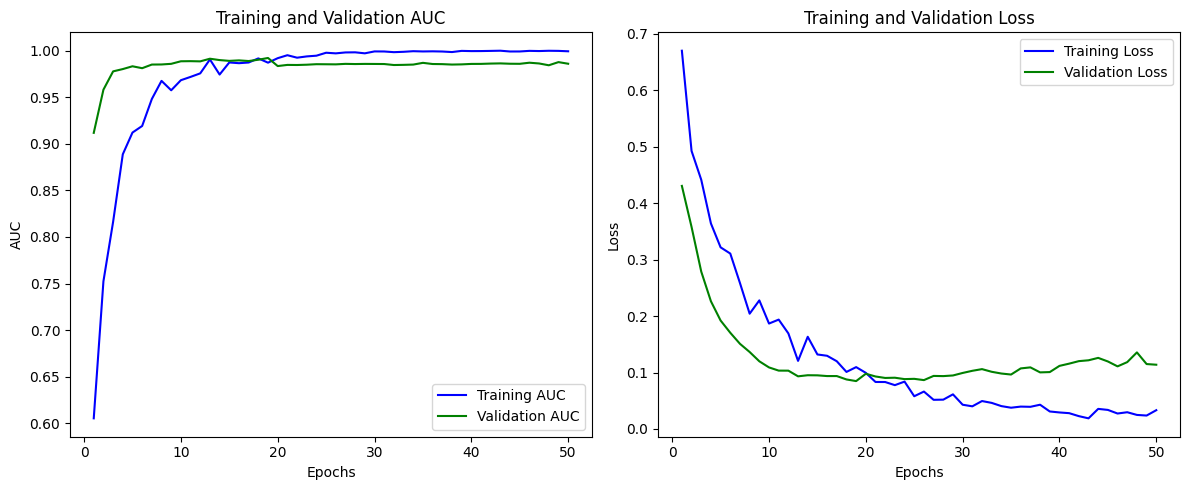

In [14]:
# Ambil nilai AUC dari riwayat training
auc = history.history['auc']
val_auc = history.history['val_auc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(auc) + 1)

# Plot AUC training dan validasi
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, auc, 'b', label='Training AUC')
plt.plot(epochs, val_auc, 'g', label='Validation AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

# Plot Loss training dan validasi
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


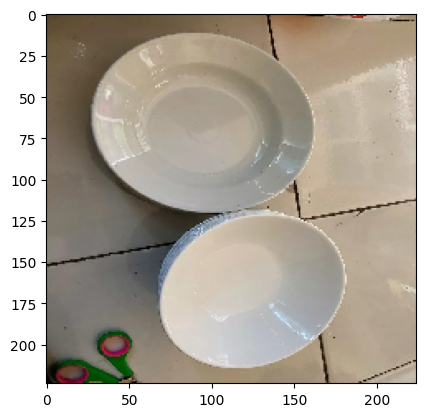

In [15]:
#Gambar yang diprediksi
img = image.load_img('/content/DatasetMultilabe_BillyJes_202255202106/Gambar005.jpg', target_size=(SIZE,SIZE,3))

img = image.img_to_array(img)
img = img/255.
plt.imshow(img)
img = np.expand_dims(img, axis=0)

classes = np.array(df.columns[2:]) #Get array of all classes
proba = model.predict(img)  #Get probabilities for each class
sorted_categories = np.argsort(proba[0])[:-11:-1]  #Get class names for top 10 categories

In [16]:
#Print classes and corresponding probabilities
for i in range(4):
    print("{}".format(classes[sorted_categories[i]])+" ({:.3})".format(proba[0][sorted_categories[i]]))

piring (1.0)
mangkok (1.0)
gelas (0.00158)
pisau (0.000254)


In [17]:
###################################################

loss, auc = model.evaluate(X_test, y_test)
print("AUC = ", (auc * 100.0), "%")

###################################################

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - auc: 0.9877 - loss: 0.1044
AUC =  98.58492016792297 %


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 844ms/step
              precision    recall  f1-score   support

       pisau       0.98      1.00      0.99        55
      piring       1.00      1.00      1.00        90
     mangkok       0.95      0.95      0.95        63
       gelas       0.98      1.00      0.99        55

   micro avg       0.98      0.99      0.98       263
   macro avg       0.98      0.99      0.98       263
weighted avg       0.98      0.99      0.98       263
 samples avg       0.98      0.99      0.99       263



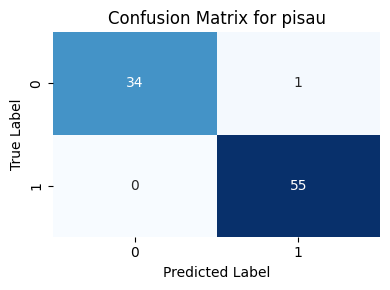

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


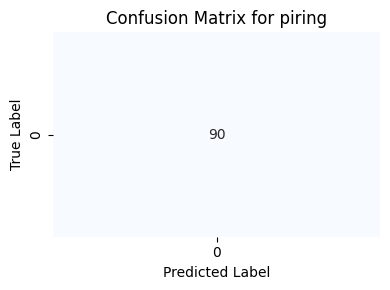

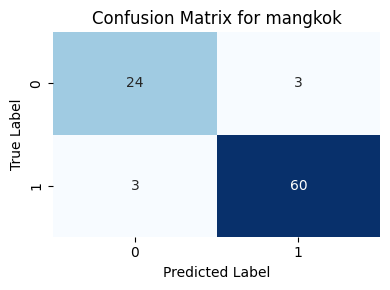

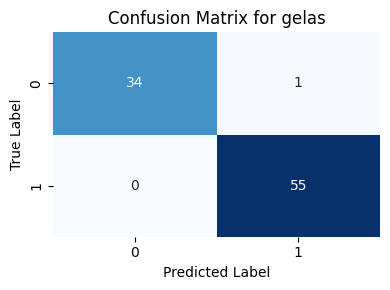

In [18]:
# Prediksi
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

# Laporan klasifikasi
print(classification_report(y_test, y_pred_classes, target_names=classes))

# Visualisasi confusion matrix untuk setiap label
for i in range(len(classes)):
    cm = confusion_matrix(y_test[:, i], y_pred_classes[:, i])

    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for {classes[i]}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()
